<a href="https://colab.research.google.com/github/dkapitan/jads-nhs-proms/blob/master/notebooks/4.0-modeling-clustering-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background to osteoarthritis case study

_taken from [narrative seminar Osteoarthritis by Hunter & Bierma-Zeinstra (2019) in the Lancet](https://github.com/dkapitan/jads-nhs-proms/blob/master/references/hunter2019osteaoarthritis.pdf)._

Outcomes from total joint replacement can be optimised if patient selection identifies marked joint space narrowing. Most improvement will be made in patients with complete joint space loss and evident bone attrition. Up to 25% of patients presenting for total joint replacement continue to complain of pain and disability 1 year after well performed surgery. Careful preoperative patient selection (including consideration of the poor outcomes that are more common in people who are depressed, have minimal radiographic disease, have minimal pain, and who are morbidly obese), shared decision making about surgery, and informing patients about realistic outcomes of surgery are needed to minimise the likelihood of dissatisfaction.

# Data Preparation

This is day 4 from the [5-day JADS NHS PROMs data science case study](https://github.com/dkapitan/jads-nhs-proms/blob/master/references/outline.md).



## Learning objectives: modeling
- ...


## Learning objectives: Hands-on Machine Learning (2nd edition)

- [Unsupervised learning (chapter 9)](https://github.com/ageron/handson-ml2/blob/master/09_unsupervised_learning.ipynb)
- [Classification (chapter 3](https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb)
- [Support-vector machines (chapter 5](https://github.com/ageron/handson-ml2/blob/master/05_support_vector_machines.ipynb)
- [Decision trees (chapter 6)](https://github.com/ageron/handson-ml2/blob/master/06_decision_trees.ipynb)
- [Ensemble learning and random forests (chapter 7](https://github.com/ageron/handson-ml2/blob/master/07_ensemble_learning_and_random_forests.ipynb)

## Recap from previous lecture
- Good outcome for knee replacement Y is measured using difference in Oxford Knee Score (OKS)
- Research has shown that an improvement in OKS score of approx. 30% is relevant ([van der Wees 2017](https://github.com/dkapitan/jads-nhs-proms/blob/master/references/vanderwees2017patient-reported.pdf)). Hence an increase of +14 points is considered a 'good' outcome.
- to account for the ceiling effect, a high final `t1_oks_score` is also considered as a good outcome (even if `delta_oks_score` is smaller than 14).

    

# Cleaning data


In [0]:
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2, VarianceThreshold
import sklearn.linear_model

#supressing warnings for readability
warnings.filterwarnings("ignore")

# To plot pretty figures directly within Jupyter
%matplotlib inline

# choose your own style: https://matplotlib.org/3.1.0/gallery/style_sheets/style_sheets_reference.html
plt.style.use('ggplot')

# Go to town with https://matplotlib.org/tutorials/introductory/customizing.html
# plt.rcParams.keys()
mpl.rc('axes', labelsize=14, titlesize=14)
mpl.rc('figure', titlesize=20)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# contants for figsize
S = (8,8)
M = (12,12)
L = (14,14)

# pandas options
pd.set_option("display.max.columns", None)
pd.set_option("display.max.rows", None)
pd.set_option("display.precision", 2)

# import data
df = pd.read_parquet('https://github.com/dkapitan/jads-nhs-proms/blob/master/data/interim/knee-provider.parquet?raw=true')

## Recap data preparation (see day 2)

In [0]:
# TO DO: refactor code into nice function
# and show how pipeline works in sklearn

comorb = ['heart_disease', 'high_bp', 'stroke', 'circulation', 'lung_disease', 'diabetes',
           'kidney_disease', 'nervous_system', 'liver_disease', 'cancer', 'depression', 'arthritis']
boolean = ['t0_assisted', 't0_previous_surgery', 't0_disability']
eq5d = ['t0_mobility', 't0_self_care', 't0_activity', 't0_discomfort', 't0_anxiety']
categorical = ['t0_symptom_period', 't0_previous_surgery', 't0_living_arrangements']

# useless variables
useless = ['t0_assisted_by', 't0_eq5d_index', 't0_eq5d_index_profile']

count_values(df[['gender'] + comorb + boolean])

# list of columns which contain 9s
cols_with_9 = [col for col in df.columns if (df[col]==9).any()]

# columns where 9 is *not* a sentinel value
cols_keep_9 = comorb + [ 't0_eq_vas', 't1_eq_vas','oks_t0_score', 'oks_t1_score']

# columns with 9 as sentinel value
cols_sentinel_9 = list(set(cols_with_9) ^ set(cols_keep_9))

from sklearn.impute import SimpleImputer

impute_median = SimpleImputer(strategy='median')
impute_most_frequent = SimpleImputer(strategy='most_frequent')

# use copy of original data
dfc = df.copy()

# replace 9 with np.nan and impute most frequent
dfc.loc[:,cols_sentinel_9] = df.loc[:,cols_sentinel_9].replace(9, np.nan)
impute_most_frequent.fit(dfc[cols_sentinel_9])

# assign imputed data
dfc.loc[:, cols_sentinel_9] = impute_most_frequent.transform(dfc[cols_sentinel_9])

# same procedure for 999 sentinel values, using impute median
eq_vas = ['t0_eq_vas', 't1_eq_vas']
dfc.loc[:, eq_vas] = dfc.loc[:,eq_vas].replace(999, np.nan)
impute_median.fit(dfc.loc[:,eq_vas])
dfc.loc[:,eq_vas] = impute_median.transform(dfc.loc[:,eq_vas])
impute_median.statistics_

# transform into boolean
dfc['female'] = dfc.loc[:,'gender'].replace({1: False, 2: True})
dfc.loc[:, comorb] = dfc.loc[:, comorb].replace({9: False, 1: True})
dfc.loc[:, boolean] = dfc.loc[:, boolean].replace({1: True, 2: False})

# helper function for counting boolean attribues
def count_boolean(series):
    '''
    Returns absolute and normalized value counts of pd.series as a dataframe with 
    index = series.name
    columns with absolute and normalized counts of each value
    '''
    try:
        count = series.value_counts().to_frame().transpose()
        norm = series.value_counts(normalize=True).to_frame().transpose()
        return count.join(norm, lsuffix='_count', rsuffix='_normalized') 
    except:
        print('Error: expecting a pandas.Series object as input. \n' + count_boolean.__doc__)
        return None

pd.concat([count_boolean(dfc[col]) for col in ['female'] + comorb + boolean]).round(2)

,1.0,2.0,9.0
gender,55749.0,74085.0,NaN
heart_disease,13051.0,NaN,126185.0
high_bp,61570.0,NaN,77666.0
stroke,2303.0,NaN,136933.0
circulation,7882.0,NaN,131354.0
lung_disease,12779.0,NaN,126457.0
diabetes,17379.0,NaN,121857.0
kidney_disease,2856.0,NaN,136380.0
nervous_system,1422.0,NaN,137814.0
liver_disease,812.0,NaN,138424.0


## Inspect categorical features (T0)


,False_count,False_normalized,True_count,True_normalized
female,55749,0.43,74085,0.57
heart_disease,126185,0.91,13051,0.09
high_bp,77666,0.56,61570,0.44
stroke,136933,0.98,2303,0.02
circulation,131354,0.94,7882,0.06
lung_disease,126457,0.91,12779,0.09
diabetes,121857,0.88,17379,0.12
kidney_disease,136380,0.98,2856,0.02
nervous_system,137814,0.99,1422,0.01
liver_disease,138424,0.99,812,0.01


In [0]:
# convert to categories
dfc.loc[:, ['provider_code', 'age_band']] = dfc.loc[:, ['provider_code', 'age_band']].astype('category')

## Discussion

### **Question:** ...
- ...


# Selecting data

## Selecting input features X

In [0]:
# input features
# TO DO: decide what to do with years?!

# feature engineering
dfc['oks_t0_pain_total'] = dfc['oks_t0_pain'] + dfc['oks_t0_night_pain']
dfc['n_comorb'] = dfc.loc[:,comorb].sum()

X_features = ['provider_code', 'female', 'age_band'] + comorb + boolean + eq5d_questions('t0') + oks_questions('t0') + ['t0_eq_vas', 'oks_t0_pain_total', 'n_comorb']
X_features

['provider_code',
 'female',
 'age_band',
 'heart_disease',
 'high_bp',
 'stroke',
 'circulation',
 'lung_disease',
 'diabetes',
 'kidney_disease',
 'nervous_system',
 'liver_disease',
 'cancer',
 'depression',
 'arthritis',
 't0_assisted',
 't0_previous_surgery',
 't0_disability',
 't0_mobility',
 't0_self_care',
 't0_activity',
 't0_discomfort',
 't0_anxiety',
 'oks_t0_pain',
 'oks_t0_night_pain',
 'oks_t0_washing',
 'oks_t0_transport',
 'oks_t0_walking',
 'oks_t0_standing',
 'oks_t0_limping',
 'oks_t0_kneeling',
 'oks_t0_work',
 'oks_t0_confidence',
 'oks_t0_shopping',
 'oks_t0_stairs',
 't0_eq_vas',
 'oks_t0_pain_total',
 'n_comorb']

## Selecting outcome Y

In [0]:
# add delta_oks_score and Y
def good_outcome(oks_t1, delta_oks, abs_threshold=43, mcid=13):
  if oks_t1 > abs_threshold or delta_oks > mcid:
    return True
  else:
    return False

dfc['delta_oks_score'] = dfc.oks_t1_score - dfc.oks_t0_score
dfc['Y'] = dfc.apply(lambda row: good_outcome(row['oks_t1_score'], row['delta_oks_score']), axis=1)
dfc.Y.value_counts(normalize=True)

True     0.66
False    0.34
Name: Y, dtype: float64

# Getting into scikit-learn: regression

## Simple linear regression
To illustrate linear regression, we use `t1_eq_vas` as numeric outcome. First we will assess whether there is a correlation between `t0` and `t1` values of `eq_vas`

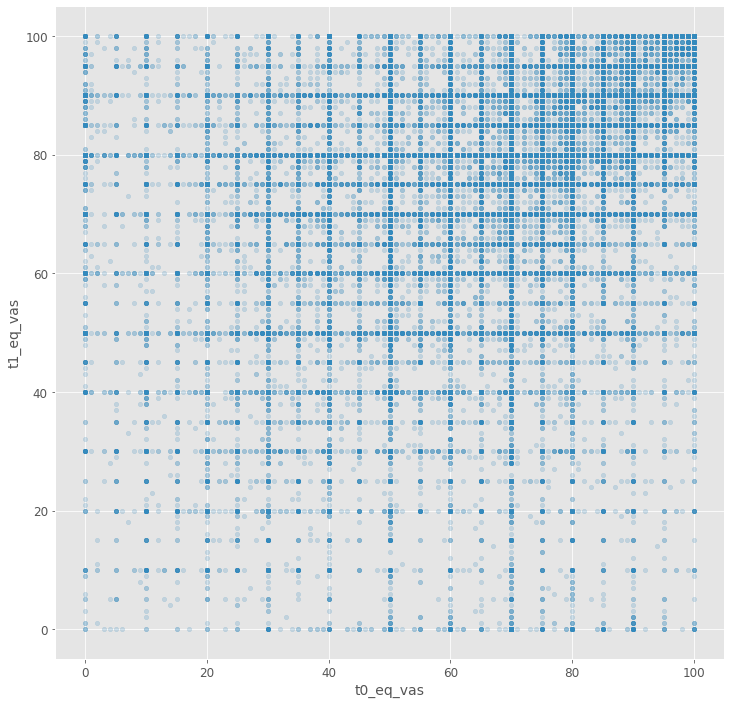

In [0]:
dfc.plot(kind='scatter', x='t0_eq_vas', y='t1_eq_vas', figsize=M, alpha=0.2);

In [0]:
from sklearn.linear_model import LinearRegression

# x needs to be a column vector or an matrix
x = dfc.t0_eq_vas.values.reshape(-1, 1)

# y is a row vector
y = dfc.t1_eq_vas.values
print(f'x: {x[:5]}\n y: {y[:5]}')

x: [[80.]
 [70.]
 [70.]
 [70.]
 [75.]]
 y: [80. 95. 98. 60. 80.]


In [0]:
# linear regression with t0_eq_vas
lr = LinearRegression().fit(x, y)
r2 = lr.score(x, y)
print(f'r2: {r2:.2f}')

r2: 0.12


## Regression with decision trees
Next, let's try more parameters to perform regression on `t1_eq_vas`.

In [0]:
from sklearn.tree import DecisionTreeRegressor

# regression can only take numeric input features
X = dfc.loc[:, X_features].select_dtypes(include='float64').drop(columns=['n_comorb'])
y = dfc.t1_eq_vas.values
dtr = DecisionTreeRegressor().fit(X,y)
dt_r2 = dtr.score(X, y)
print(f'DecisionTreeRegressor r2: {dt_r2:.2f}')

DecisionTreeRegressor r2: 0.97


In [0]:
# this doesn't make sense, probably overfitting
dtr = DecisionTreeRegressor(max_depth=5).fit(X,y)
dt_r2 = dtr.score(X, y)
print(f'DecisionTreeRegressor r2: {dt_r2:.2f}')

DecisionTreeRegressor r2: 0.18


# Conclusion and reflection

## Discussion of results

* ...
* ...

## Checklist for results from data preparation process
* Input regarding the moment of prediction
* Input for data cleaning (handling missing data; removing variables not known at time of prediction, near-zero variance variables, etc)
* Input for feature engineering (adjusting variables based on tree-analyses, based on correlations, based on domain-analysis)
* Input for defining the outcome variable Y
* Input for defining the business objective in terms of generalizability (in case of missing Y values)
* Input for choosing the business objective in case there are still multiple options at the table
* Input for defining the scope of the business objective (e.g. limiting to a subgroup to get a better balanced outcome variable)
* A potential revision of the goal of your business objective
* Input for which variables and combination of variables seem particularly relevant within the to-be-developed algorithms 